# Creating an LRP Analyzer

We start out by loading a small convolutional neural network:

In [1]:
using RelevancePropagation
using Flux

model = Chain(
    Chain(
        Conv((3, 3), 3 => 8, relu; pad=1),
        Conv((3, 3), 8 => 8, relu; pad=1),
        MaxPool((2, 2)),
        Conv((3, 3), 8 => 16; pad=1),
        BatchNorm(16, relu),
        Conv((3, 3), 16 => 8, relu; pad=1),
        BatchNorm(8, relu),
    ),
    Chain(Flux.flatten, Dense(2048 => 512, relu), Dropout(0.5), Dense(512 => 100, softmax)),
);

This model contains two chains: the convolutional layers and the fully connected layers.

## Model preparation

### Stripping the output softmax
When using LRP, it is recommended to explain output logits instead of probabilities.
This can be done by stripping the output softmax activation from the model
using the `strip_softmax` function:

In [2]:
model = strip_softmax(model)

Chain(
  Chain(
    Conv((3, 3), 3 => 8, relu, pad=1),  # 224 parameters
    Conv((3, 3), 8 => 8, relu, pad=1),  # 584 parameters
    MaxPool((2, 2)),
    Conv((3, 3), 8 => 16, pad=1),       # 1_168 parameters
    BatchNorm(16, relu),                # 32 parameters, plus 32
    Conv((3, 3), 16 => 8, relu, pad=1),  # 1_160 parameters
    BatchNorm(8, relu),                 # 16 parameters, plus 16
  ),
  Chain(
    Flux.flatten,
    Dense(2048 => 512, relu),           # 1_049_088 parameters
    Dropout(0.5),
    Dense(512 => 100),                  # 51_300 parameters
  ),
)         # Total: 16 trainable arrays, 1_103_572 parameters,
          # plus 4 non-trainable, 48 parameters, summarysize 4.213 MiB.

If you don't remove the output softmax,
model checks will fail.

### Model canonization
LRP is not invariant to a model's implementation.
Applying the `GammaRule` to two linear layers in a row will yield different results
than first fusing the two layers into one linear layer and then applying the rule.
This fusing is called "canonization" and can be done using the `canonize` function:

In [3]:
model_canonized = canonize(model)

Chain(
  Conv((3, 3), 3 => 8, relu, pad=1),    # 224 parameters
  Conv((3, 3), 8 => 8, relu, pad=1),    # 584 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 8 => 16, relu, pad=1),   # 1_168 parameters
  Conv((3, 3), 16 => 8, relu, pad=1),   # 1_160 parameters
  BatchNorm(8, relu),                   # 16 parameters, plus 16
  Flux.flatten,
  Dense(2048 => 512, relu),             # 1_049_088 parameters
  Dropout(0.5),
  Dense(512 => 100),                    # 51_300 parameters
)         # Total: 14 trainable arrays, 1_103_540 parameters,
          # plus 2 non-trainable, 16 parameters, summarysize 4.212 MiB.

After canonization, the first `BatchNorm` layer has been fused into the preceding `Conv` layer.
The second `BatchNorm` layer wasn't fused
since its preceding `Conv` layer has a ReLU activation function.

### Flattening the model
RelevancePropagation.jl's LRP implementation supports nested Flux Chains and Parallel layers.
However, it is recommended to flatten the model before analyzing it.

LRP is implemented by first running a forward pass through the model,
keeping track of the intermediate activations, followed by a backward pass
that computes the relevances.

To keep the LRP implementation simple and maintainable,
RelevancePropagation.jl does not pre-compute "nested" activations.
Instead, for every internal chain, a new forward pass is run to compute activations.

By "flattening" a model, this overhead can be avoided.
For this purpose, RelevancePropagation.jl provides the function `flatten_model`:

In [4]:
model_flat = flatten_model(model)

Chain(
  Conv((3, 3), 3 => 8, relu, pad=1),    # 224 parameters
  Conv((3, 3), 8 => 8, relu, pad=1),    # 584 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 8 => 16, pad=1),         # 1_168 parameters
  BatchNorm(16, relu),                  # 32 parameters, plus 32
  Conv((3, 3), 16 => 8, relu, pad=1),   # 1_160 parameters
  BatchNorm(8, relu),                   # 16 parameters, plus 16
  Flux.flatten,
  Dense(2048 => 512, relu),             # 1_049_088 parameters
  Dropout(0.5),
  Dense(512 => 100),                    # 51_300 parameters
)         # Total: 16 trainable arrays, 1_103_572 parameters,
          # plus 4 non-trainable, 48 parameters, summarysize 4.212 MiB.

This function is called by default when creating an LRP analyzer.
Note that we pass the unflattened model to the analyzer, but `analyzer.model` is flattened:

In [5]:
analyzer = LRP(model)
analyzer.model

Chain(
  Conv((3, 3), 3 => 8, relu, pad=1),    # 224 parameters
  Conv((3, 3), 8 => 8, relu, pad=1),    # 584 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 8 => 16, pad=1),         # 1_168 parameters
  BatchNorm(16, relu),                  # 32 parameters, plus 32
  Conv((3, 3), 16 => 8, relu, pad=1),   # 1_160 parameters
  BatchNorm(8, relu),                   # 16 parameters, plus 16
  Flux.flatten,
  Dense(2048 => 512, relu),             # 1_049_088 parameters
  Dropout(0.5),
  Dense(512 => 100),                    # 51_300 parameters
)         # Total: 16 trainable arrays, 1_103_572 parameters,
          # plus 4 non-trainable, 48 parameters, summarysize 4.212 MiB.

If this flattening is not desired, it can be disabled
by passing the keyword argument `flatten=false` to the `LRP` constructor.

## LRP rules
The following examples will be run on a pre-trained LeNet-5 model:

In [6]:
using BSON

model = BSON.load("../model.bson", @__MODULE__)[:model] # load pre-trained LeNet-5 model

Chain(
  Conv((5, 5), 1 => 6, relu),           # 156 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 6 => 16, relu),          # 2_416 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(256 => 120, relu),              # 30_840 parameters
  Dense(120 => 84, relu),               # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
)                   # Total: 10 arrays, 44_426 parameters, 174.867 KiB.

We also load the MNIST dataset:

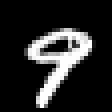

In [7]:
using MLDatasets
using ImageCore, ImageIO, ImageShow

index = 10
x, y = MNIST(Float32, :test)[10]
input = reshape(x, 28, 28, 1, :)

convert2image(MNIST, x)

By default, the `LRP` constructor will assign the `ZeroRule` to all layers.

In [8]:
analyzer = LRP(model)

LRP(
  Conv((5, 5), 1 => 6, relu)  => ZeroRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Conv((5, 5), 6 => 16, relu) => ZeroRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Flux.flatten                => ZeroRule(),
  Dense(256 => 120, relu)     => ZeroRule(),
  Dense(120 => 84, relu)      => ZeroRule(),
  Dense(84 => 10)             => ZeroRule(),
)

This ana lyzer will return heatmaps that look identical to the `InputTimesGradient` analyzer
from [ExplainableAI.jl](https://github.com/Julia-XAI/ExplainableAI.jl).
We can visualize `Explanation`s by computing a `heatmap` using either
[VisionHeatmaps.jl](https://julia-xai.github.io/XAIDocs/VisionHeatmaps/stable/) or
[TextHeatmaps.jl](https://julia-xai.github.io/XAIDocs/TextHeatmaps/stable/),
either for images or text, respectively.

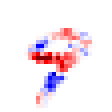

In [9]:
using VisionHeatmaps

heatmap(input, analyzer)

LRP's strength lies in assigning different rules to different layers,
based on their functionality in the neural network[^1].
RelevancePropagation.jl implements many LRP rules out of the box,
but it is also possible to *implement custom rules*.

To assign different rules to different layers,
use one of the composites presets,
or create your own composite, as described in
*Assigning rules to layers*.

In [10]:
composite = EpsilonPlusFlat() # using composite preset EpsilonPlusFlat

Composite(
  GlobalTypeMap(  # all layers
    Flux.Conv               => ZPlusRule(),
    Flux.ConvTranspose      => ZPlusRule(),
    Flux.CrossCor           => ZPlusRule(),
    Flux.Dense              => EpsilonRule{Float32}(1.0f-6),
    Flux.Scale              => EpsilonRule{Float32}(1.0f-6),
    Flux.LayerNorm          => LayerNormRule(),
    typeof(NNlib.dropout)   => PassRule(),
    Flux.AlphaDropout       => PassRule(),
    Flux.Dropout            => PassRule(),
    Flux.BatchNorm          => PassRule(),
    typeof(Flux.flatten)    => PassRule(),
    typeof(MLUtils.flatten) => PassRule(),
    typeof(identity)        => PassRule(),
 ),
  FirstLayerTypeMap(  # first layer
    Flux.Conv          => FlatRule(),
    Flux.ConvTranspose => FlatRule(),
    Flux.CrossCor      => FlatRule(),
 ),
)

In [11]:
analyzer = LRP(model, composite)

LRP(
  Conv((5, 5), 1 => 6, relu)  => FlatRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Conv((5, 5), 6 => 16, relu) => ZPlusRule(),
  MaxPool((2, 2))             => ZeroRule(),
  Flux.flatten                => PassRule(),
  Dense(256 => 120, relu)     => EpsilonRule{Float32}(1.0f-6),
  Dense(120 => 84, relu)      => EpsilonRule{Float32}(1.0f-6),
  Dense(84 => 10)             => EpsilonRule{Float32}(1.0f-6),
)

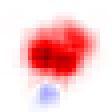

In [12]:
heatmap(input, analyzer)

## Computing layerwise relevances
If you are interested in computing layerwise relevances,
call `analyze` with an LRP analyzer and the keyword argument
`layerwise_relevances=true`.

The layerwise relevances can be accessed in the `extras` field
of the returned `Explanation`:

In [13]:
expl = analyze(input, analyzer; layerwise_relevances=true)
expl.extras.layerwise_relevances

(Float32[-1.5046089f-6 -1.5046089f-6 … 4.4148962f-8 0.0; -1.5046089f-6 -1.5046089f-6 … 4.4148962f-8 0.0; … ; 6.1168203f-6 6.1168203f-6 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;;], Float32[-3.7615224f-5 0.0 … 1.103724f-6 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0001529205 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;;], Float32[-3.7615224f-5 0.00021888175 … 0.000114222385 1.103724f-6; 0.00018855373 0.00027439542 … 0.00020195934 -3.4702516f-5; … ; -2.6229336f-5 7.008412f-5 … -2.8691686f-6 0.0; 0.0001529205 0.00029437395 … 0.0 0.0;;; 0.0 0.0 … -0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 -0.0; 0.0 0.0 … -0.0 0.0;;;

Note that the layerwise relevances are only kept for layers in the outermost `Chain` of the model.
Since we used a flattened model, we obtained all relevances.

## Performance tips
### Using LRP with a GPU
All LRP analyzers support GPU backends,
building on top of [Flux.jl's GPU support](https://fluxml.ai/Flux.jl/stable/gpu/).
Using a GPU only requires moving the input array and model weights to the GPU.

For example, using [CUDA.jl](https://github.com/JuliaGPU/CUDA.jl):

```julia
using CUDA, cuDNN
using Flux
using RelevancePropagation

# move input array and model weights to GPU
input = input |> gpu # or gpu(input)
model = model |> gpu # or gpu(model)

# analyzers don't require calling `gpu`
analyzer = LRP(model)

# explanations are computed on the GPU
expl = analyze(input, analyzer)
```

Some operations, like saving, require moving explanations back to the CPU.
This can be done using Flux's `cpu` function:

```julia
val = expl.val |> cpu # or cpu(expl.val)

using BSON
BSON.@save "explanation.bson" val
```

### Using LRP without a GPU
Using Julia's package extension mechanism,
RelevancePropagation.jl's LRP implementation can optionally make use of
[Tullio.jl](https://github.com/mcabbott/Tullio.jl) and
[LoopVectorization.jl](https://github.com/JuliaSIMD/LoopVectorization.jl)
for faster LRP rules on dense layers.

This only requires loading the packages before loading RelevancePropagation.jl:
```julia
using LoopVectorization, Tullio
using RelevancePropagation
```

[^1]: G. Montavon et al., [Layer-Wise Relevance Propagation: An Overview](https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*